#### Fractional Cascading

For the 2-D range search problem, we implemented a 2-level WBST. The first level contains nodes sorted by x-coordinate. Then each internal node contains a secondary WBST which contains all points in the subtree rooted at that internal node and sorted by the y-coordinate. Then construction time for this range tree is $O(n \log n)$, the space consumption is $O(n \log n)$ and the query time is $O(k + \log^2 n)$. To perform a query on the 2-D range $Q = [x_1, x_2] \times [y_1, y_2]$, we first do a 1-D range search over the x-coordinate range $[x_1, x_2]$ to find all candidate secondary trees. Then on each of these candidate secondary trees, we perform a 1-D range search over the y-coordinate range $[y_1, y_2]$ to find all points in $Q$. Now, the important thing to note here is that the 1-D range query on all the candidate secondary trees is over the same range. Furthermore, since candidate secondary trees are rooted at nodes along a given path (paths from $successor(x_1)$ and $predecessor(x_2)$ to some lowest common ancestor), each of the candidate subtrees contain a subset of points from their ancestor's subtrees, so there is a lot of reducnant work being done during the 1-D range search in the secondary trees. We can take advantage of this fact to speed up the query time via `fractional cascading`, which involves maintaining a sorted array inside each node in the first level tree instead of a secondary tree and using pointers that connect elements from different secondary arrays.

Suppose `w` is an internal node in the first level tree. Let `u` and `v` be the left and right children respectively. 
```
     w
   /   \
  u     v 
```

Let $L_y(w)$ be the array of all points in the sub-tree rooted at `w` sorted by y-coordinate. Similarly we have arrays $L_y(u)$ and $L_y(v)$ for nodes `u` and `v` respectively. Now, for each element $p \in L_y(w)$, we create a pointer to the element $q \in L_y(u)$ such that $q = successor(p)$. We can do this in $O(|L_y(w)|)$ by just scanning both arrays left to right in lockstep. Similarly, we also create pointers from $L_y(w)$ elements to their successors in $L_y(v)$. We construct these secondary arrays in a top-down manner, starting from the root node of the first level tree, and then performing in-order (DFS) or level-order (BFS) traversal and constructing the secondary arrays inside visited nodes and creating pointers connecting the elements between each node's secondary array elements and the parent node's secondary array elements. Since the total number of elements across the secondary arrays for all the nodes v with $depth(v) = i$ of the tree is $O(n)$, i.e. $\sum_{v \land depth(v)=i} |L_y(v)| = O(n)$, the cost of constructing all secondary arrays is $O(n \log n)$ since there are at most $\log n$ levels in the tree. The space consumption is also $O(n \log n)$.

To perform a 2-D range query, like before we first identify nodes $[a', b'] =[successor(x_1),predecessor(x_2)]$  and their lowest common ancestor ($LCA$), and then found the paths $L_a$ and $L_b$, i.e. paths from $LCA$ to $a'$ and $b'$ respectively. Then starting at the left child of $LCA$, we just need to perform a single binary search in $L_y(LCA.left)$ to find $successor(y_1)$. If this node $LCA.left$ is a candidate (i.e. if it's $x$ value is $\geq x_1$) we just scan $L_y(LCA.left)$ linearly from $successor(y_1)$ until we reach a point larger than $y_2$, then report all points in that interval. Then we simply walk down one step along the path $L_a$ to a descendent node and use the pointer from $successor(y_1)$ of the parent node to get the successor of that point in the secondary array of this descendent node. If this descendent node is a candidate (i.e. if it's $x$ value is $\geq x_1$), then we again do a linear scan from the successor in the secondary array and report all points found. Thus we keep walking doing the path, following pointers to get the $successor(y_1)$ inside each candicate secondary array and doing a linear scan in that array and reporting the points. We repeat the same thing starting at the right child of $LCA$ and walking down the path $L_b$. 

Note that we are no longer needing to perform binary searches to find $successor(y_1)$ and $predecessor(y_2)$ at every candidate node $v$ on the paths, so the cost of the 1-D range search at each candidate secondary array is $O(k_v)$, where $k_v$ is the number of reported points from the secondary array of that node. Compare this to the case without fractional cascading where we needed to perform binary searches in the secondary tree and the cost of the 1-D range search was $O\Big(k_v + \log(|P(v)|)\Big) = O(k_v +\log n)$. So the total time for the 2-D range query is:

$$O(\log n) + \sum_v O(k_v) = O(k + \log n)$$

where the $O(\log n)$ is from the $O(1)$ binary searches that need to be performed in $L_y(LCA.left)$ and $L_y(LCA.right)$.

This fractional cancading method generalizes to higher dimensions. For a d-dimensional range query, we construct a multi-level range tree in the first $d-1$ dimensions and then on the last dimension, we construct sorted arrays with pointers instead of trees, just like we did for the second dimension in the 2-D case.



In [30]:
from collections import defaultdict
from graphviz import Digraph, Source
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def add_nodes_edges(graph, node, counter=0):
    if node is not None:
        root = str(counter)
        graph.node(root, str(node.data), fontsize='10')
        if node.left is not None:
            left = str(counter + 1)
            graph.edge(root, left)
            counter = add_nodes_edges(graph, node.left, counter + 1)
        else:
            if node.right is not None:
                # Add a dummy node if the node has no left child
                left = str(counter + 1)
                graph.node(left, "null")
                graph.edge(root, left)
                counter += 1

        if node.right is not None:
            right = str(counter + 1)
            graph.edge(root, right)
            counter = add_nodes_edges(graph, node.right, counter + 1)
        else:
            if node.left is not None:    
                # Add a dummy node if the node has no right child
                right = str(counter + 1)
                graph.node(right, "null")
                graph.edge(root, right)
                counter += 1

    return counter

def visualize_tree(root):
    graph = Digraph()
    add_nodes_edges(graph, root)
    return Source(graph.source)  


def plot_points(P, Q, found_points):
    Px = [p[0] for p in P]
    Py = [p[1] for p in P]

    # set figure size 
    plt.figure(figsize=(8, 8))

    # plot the points on a 2D plane
    plt.plot(Px, Py, 'o', markersize=5)
    plt.xlabel('x')
    plt.ylabel('y')

    # create a rectangle
    x1, x2 = Q[0]
    y1, y2 = Q[1]
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    # add the rectangle to the plot
    plt.gca().add_patch(rect)

    # draw thin circle around each reported point on the plot
    for p in found_points:
        plt.plot(p[0], p[1], '+', markersize=4, markerfacecolor='none', markeredgecolor='r')

    plt.show()
    

In [36]:
class Node:
    def __init__(self, key=None, data=None, parent=None, left=None, right=None):
        self.key = key
        self.data = data
        self.parent = parent
        self.left = left
        self.right = right
        self.secondary_array = None


class ArrayNode:
    def __init__(self, data=None, left_successor=None, right_successor=None):
        self.data = data
        self.left_successor = left_successor 
        self.right_successor = right_successor 


# 2-D range tree with fractional cascading
class range2d:
    def __init__(self, P):
        self.size = len(P)
        self.root = self.construct_tree(P)

    @property
    def get_root(self):
        return self.root

    # bst search for a given key
    def search(self, key):
        node = self.root
        while node is not None:
            if key < node.key:
                node = node.left
            elif key > node.key:
                node = node.right    
            else:
                return node    
        return None 

    # function for constructing a weight-balanced binary search tree on a set of keys
    def construct_tree(self, P):    
        # create two copies of the points, one sorted by x-coordinates and the other by y-coordinates
        P_x = sorted(P, key=lambda x: x[0])
        P_y = sorted(P, key=lambda x: x[1])
        # recursively build the first level tree
        root = self.construct_wbst(P_x, 0, len(P_x)-1, l=0)
        # build the secondary level arrays top-down, starting from the root
        self.construct_secondary_level(root, P_y)    
        
        return root
    
    def construct_secondary_level(self, root, P_y):
        # create secondary array of root
        root.secondary_array = [ArrayNode(data=p) for p in P_y]
        # perform level-order traversal/BFS of the primary tree to build the secondary arrays
        queue = [root]
        while len(queue) > 0:
            node = queue.pop(0)
            # scan the points in the y-sorted secondary array of the node and create y-sorted partitions for the left and right subtree 
            P_yL = []
            P_yR = []
            for p in node.secondary_array:
                if p.data[0] < node.data[0]:
                    P_yL.append(p.data)
                else:
                    P_yR.append(p.data)

            # add the left and right children of the node to the queue
            if node.left is not None:
                queue.append(node.left)
                # construct the secondary array for the left child
                self.construct_secondary_array(P_yL, node.left, node, left_child=True)
            if node.right is not None:
                queue.append(node.right)
                # construct the secondary array for the left child
                self.construct_secondary_array(P_yR, node.right, node, left_child=False)

    # construct a secondary array array inside a node and create pointers between node and it's parent's secondary array elements
    def construct_secondary_array(self, Py_u, u, parent, left_child=True):
        # create a secondary array in node u
        u.secondary_array = [ArrayNode(data=p) for p in Py_u]   
        #print(f"Parent node {parent.data}, secondary array: {[p.data for p in parent.secondary_array]}")
        #print(f"Child node {u.data}, secondary array: {[p.data for p in u.secondary_array]}")

        # create pointers from parents secondary array elements to successors in child's secondary array
        qi = 0
        pi = 0
        while pi < len(parent.secondary_array) and qi < len(u.secondary_array):
            p = parent.secondary_array[pi]
            q = u.secondary_array[qi]
            if q.data[1] >= p.data[1]:
                if left_child:
                    p.left_successor = q
                else:
                    p.right_successor = q
                pi += 1     
            else: 
                qi += 1
        
                
    # recursive function for constructing a weight-balanced binary search tree
    def construct_wbst(self, P, lo, hi, l):
        # find the median of the sorted keys
        m = (lo+hi+1) // 2
        # create a node with the median key
        node = Node(key=P[m][l], data=P[m])
        # recursively build the left subtree
        if lo < m:
            node.left = self.construct_wbst(P, lo, m-1, l)
            node.left.parent = node
        if hi > m:
            node.right = self.construct_wbst(P, m+1, hi, l)
            node.right.parent = node

        return node     
 
    # report all points in the 2d range Q = [x1,x2] x [y1,y2]
    def report_range_2d(self, Q):
        x1, x2 = Q[0]
        y1, y2 = Q[1]
        #print(f"Q = [{x1}, {x2}] x [{y1}, {y2}]")

        # first find the successor(x1) and predecessor(x2)
        ax = self.find_successor(self.root, x1)
        bx = self.find_predecessor(self.root, x2)
        print(f"ax = {ax.data if ax is not None else None}, bx = {bx.data if bx is not None else None}")


        if ax is None or bx is None:
            return []
        
        # find LCA in the primary tree
        lca = self.find_lca(self.root, ax, bx)

        range_nodes = []

        # check if the LCA is in the range [y1, y2]
        if lca.data[1] >= y1 and lca.data[1] <= y2:
            range_nodes.append(lca)

        # walk up from ax to LCA to find nodes in the path which are in the range [x1, x2]
        node = ax
        while node != lca:
            if node.key >= x1:
                #print(f"Found node {node.data} in the x-range [{x1}, {x2}]")
                # check if the node is also in the range [y1, y2]
                if node.data[1] >= y1 and node.data[1] <= y2:
                    #print(f"Found node {node.data} in the y-range [{y1}, {y2}]")
                    range_nodes.append(node)
                # perform 1d range query on the secondary tree rooted at the right child node
                if node.right is not None:
                    if node.right.secondary_tree is None:
                        # if right child is a leaf node, then just check if it is in the range [y1, y2]
                        if node.right.data[1] >= y1 and node.right.data[1] <= y2:
                            #print(f"Found node {node.right.data} in the y-range [{y1}, {y2}]")
                            range_nodes.append(node.right)
                    else:    
                        #print(f"Secondary tree rooted at right-child {node.right.secondary_tree.data} is:")
                        #display(visualize_tree(node.right.secondary_tree))
                        range_nodes_y = self.report_range_1d(node.right.secondary_tree, y1, y2)
                        range_nodes.extend(range_nodes_y)
                        #print(f"Found nodes in the y-range [{y1}, {y2}] : {[n.data for n in range_nodes_y]}")

            node = node.parent

        # walk up from bx to LCA to find nodes in the path which are in the range [x1, x2]
        node = bx
        while node != lca:
            if node.key <= x2:
                #print(f"Found node {node.data} in the x-range [{x1}, {x2}]")
                # check if the node is also in the range [y1, y2]
                if node.data[1] >= y1 and node.data[1] <= y2:
                    #print(f"Found node {node.data} in the y-range [{y1}, {y2}]")
                    range_nodes.append(node)
                # perform 1d range query on the secondary tree rooted at the left child node
                if node.left is not None:
                    if node.left.secondary_tree is None:
                        # if left child is a leaf node, then just check if it is in the range [y1, y2]
                        if node.left.data[1] >= y1 and node.left.data[1] <= y2:
                            #print(f"Found node {node.left.data} in the y-range [{y1}, {y2}]")
                            range_nodes.append(node.left)
                    else:        
                        #print(f"Secondary tree rooted at left-child {node.left.secondary_tree.data} is:")
                        #display(visualize_tree(node.left.secondary_tree))
                        range_nodes_y = self.report_range_1d(node.left.secondary_tree, y1, y2)
                        range_nodes.extend(range_nodes_y)
                        #print(f"Found nodes in the y-range [{y1}, {y2}] : {[n.data for n in range_nodes_y]}")

            node = node.parent

        range_points = [node.data for node in range_nodes]
        print(f"Points found in the range [{x1}, {x2}] x [{y1}, {y2}] are: {range_points}")

        return range_points

    
    # report all keys in the 1d range [x1, x2] contained in the tree rooted at the given node
    def report_range_1d(self, node, x1, x2, get_subtree_nodes=False):
        # first find the successor(x1) and predecessor(x2)
        a = self.find_successor(node, x1)
        b = self.find_predecessor(node, x2)

        if a is None or b is None:
            return []
        
        # find LCA
        lca = self.find_lca(node, a, b)

        # walk up from a to LCA, collecting all keys in the path which are in the range [x1, x2]
        range_nodes_left = []
        node = a
        while node != lca:
            if node.key >= x1:
                range_nodes_left.append(node)
                if node.right is not None:
                    range_nodes_left.extend(self.report_subtree(node.right))

            node = node.parent

        # walk up from b to LCA, collecting all keys in the path which are in the range [x1, x2]
        range_nodes_right = []
        node = b
        while node != lca:
            if node.key <= x2:
                range_nodes_right.append(node)
                if node.left is not None:
                    range_nodes_right.extend(self.report_subtree(node.left))

            node = node.parent

        range_nodes_right.reverse()
        range_nodes = range_nodes_left + [lca] + range_nodes_right
        return range_nodes


    # report all nodes in the subtree rooted at a given node
    def report_subtree(self, node):
        subtree_nodes = [node]
        # perform level order traversal/BFS to get all nodes in the subtree
        queue = [node]
        while len(queue) > 0:
            node = queue.pop(0)
            if node.left is not None:
                queue.append(node.left)
                subtree_nodes.append(node.left)
            if node.right is not None:
                queue.append(node.right)
                subtree_nodes.append(node.right)

        return subtree_nodes    


    # find lowest common ancestor of two nodes in the tree rooted at the given node
    def find_lca(self, node, a, b):
        while True:
            if node.key > a.key and node.key > b.key:
                node = node.left
            elif node.key< a.key and node.key < b.key:
                node = node.right
            else:
                return node        

    # find predecessor of a given key in the tree rooted at the given node
    def find_predecessor(self, node, key):
        predecessor = None
        while node is not None:
            if key < node.key:
                node = node.left
            elif key > node.key:
                predecessor  = node
                node = node.right    
            else:
                return node    
        
        return predecessor
    
    # find successor of a given key in the tree rooted at the given node
    def find_successor(self, node, key):
        successor = None
        while node is not None:
            if key < node.key:
                successor = node
                node = node.left
            elif key > node.key:
                node = node.right    
            else:
                return node    
        
        return successor



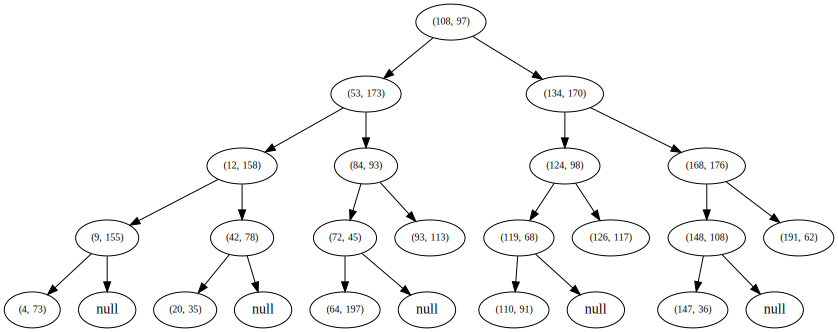

In [37]:
random.seed(10)

# draw random integers between 0 and 100 without replacement
N = 20
Px = random.sample(range(1,200), N)
Py = random.sample(range(1,200), N)
P = list(zip(Px, Py))
tree = range2d(P)

visualize_tree(tree.get_root)

In [41]:
u = tree.get_root
uL = u.left
uR = u.right

uLL = uL.left

print(f"u {u.data}, secondary array: {[p.data for p in u.secondary_array]}")
print(f"uL {uL.data},  secondary array: {[p.data for p in uL.secondary_array]}")
print(f"uR {uR.data}, secondary array: {[p.data for p in uR.secondary_array]}")
#print(f"uLL {uLL.data}, secondary array: {[p.data for p in uLL.secondary_array]}")

u (108, 97), secondary array: [(20, 35), (147, 36), (72, 45), (191, 62), (119, 68), (4, 73), (42, 78), (110, 91), (84, 93), (108, 97), (124, 98), (148, 108), (93, 113), (126, 117), (9, 155), (12, 158), (134, 170), (53, 173), (168, 176), (64, 197)]
uL (53, 173),  secondary array: [(20, 35), (72, 45), (4, 73), (42, 78), (84, 93), (93, 113), (9, 155), (12, 158), (53, 173), (64, 197)]
uR (134, 170), secondary array: [(147, 36), (191, 62), (119, 68), (110, 91), (108, 97), (124, 98), (148, 108), (126, 117), (134, 170), (168, 176)]


In [42]:
for p in u.secondary_array:
    print(f"p {p.data}, left_successor: {p.left_successor.data if p.left_successor is not None else None}")

p (20, 35), left_successor: (20, 35)
p (147, 36), left_successor: (72, 45)
p (72, 45), left_successor: (72, 45)
p (191, 62), left_successor: (4, 73)
p (119, 68), left_successor: (4, 73)
p (4, 73), left_successor: (4, 73)
p (42, 78), left_successor: (42, 78)
p (110, 91), left_successor: (84, 93)
p (84, 93), left_successor: (84, 93)
p (108, 97), left_successor: (93, 113)
p (124, 98), left_successor: (93, 113)
p (148, 108), left_successor: (93, 113)
p (93, 113), left_successor: (93, 113)
p (126, 117), left_successor: (9, 155)
p (9, 155), left_successor: (9, 155)
p (12, 158), left_successor: (12, 158)
p (134, 170), left_successor: (53, 173)
p (53, 173), left_successor: (53, 173)
p (168, 176), left_successor: (64, 197)
p (64, 197), left_successor: (64, 197)


In [43]:
for p in u.secondary_array:
    print(f"p {p.data}, right_successor: {p.right_successor.data if p.right_successor is not None else None}")

p (20, 35), right_successor: (147, 36)
p (147, 36), right_successor: (147, 36)
p (72, 45), right_successor: (191, 62)
p (191, 62), right_successor: (191, 62)
p (119, 68), right_successor: (119, 68)
p (4, 73), right_successor: (110, 91)
p (42, 78), right_successor: (110, 91)
p (110, 91), right_successor: (110, 91)
p (84, 93), right_successor: (108, 97)
p (108, 97), right_successor: (108, 97)
p (124, 98), right_successor: (124, 98)
p (148, 108), right_successor: (148, 108)
p (93, 113), right_successor: (126, 117)
p (126, 117), right_successor: (126, 117)
p (9, 155), right_successor: (134, 170)
p (12, 158), right_successor: (134, 170)
p (134, 170), right_successor: (134, 170)
p (53, 173), right_successor: (168, 176)
p (168, 176), right_successor: (168, 176)
p (64, 197), right_successor: None
